### Load relevant libraries

In [1]:
from bs4 import BeautifulSoup
from bs4.dammit import EncodingDetector
import requests
from os import path, getcwd
import numpy as np
import openai
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()
import json

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

C:\Users\Bryce\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### identify links on webpage

In [2]:
def get_soup(html):
    resp = requests.get(html)
    http_encoding = resp.encoding if 'charset' in resp.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(resp.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup = BeautifulSoup(resp.content, from_encoding=encoding)
    return soup

### create list with links from webpage

In [3]:
def get_links(soup):
    http_link_list = [] 
    for link in soup.find_all('a', href=True):
        if link['href'][0] != '/': 
            http_link_list.append(link['href'].strip("'"))
    return http_link_list 

### pull tags from webpage

In [4]:
def get_ps(soup):
    http_link_list = [] 
    for link in soup.find_all('b'):
        http_link_list.append(link.get_text())
    return http_link_list 

In [5]:
def get_ps_i(soup):
    game_header_list = [] 
    for link in soup.find_all('i'):
        game_header_list.append(link.get_text())
    return game_header_list 

In [6]:
def get_ps_td(soup):
    td_text = [] 
    for link in soup.find_all('td'):
        td_text.append(link.get_text())
    return td_text

In [7]:
def get_ps_h3(soup):
    h3_text = [] 
    for link in soup.find_all('h3'):
        h3_text.append(link.get_text())
    return h3_text

### get text from an array

In [8]:
def get_text(text_array):
    text = " ".join(text_array)
    return text

### get text from all interviews in list

In [9]:
def get_interview_text_t(interview_list):
    text_return_t = []
    for i in interview_list:
        soup = get_soup(i)
        interview = get_ps_td(soup)[13]
        c = interview.find('Q.')
        d = interview.find('FastScripts')  
        text_array_t = interview[c:d]
        text_return_t.append(text_array_t)
    return text_return_t

### clean transcript text

In [10]:
def clean_text(interview_text):
    clean_text_n = []
    for ele in interview_text:
        ele = ele.strip()
        ele = ele.replace('\r','')
        ele = ele.replace('Ã‚Â\xa0','')
        clean_text_n.append(ele)
    return clean_text_n

### split questions

In [11]:
def sort_q(filtered_text):
    questions = []
    for ele in filtered_text:
        if ele == filtered_text[0]:
            questions.append(ele)
        elif 'Q.' in ele:
            questions.append(ele)
        else:
            None
    return questions      

### identify question indices

In [12]:
def q_index(filtered_text):
    q_index = []
    for ele in filtered_text:
        if ele == filtered_text[0]:
            q_index.append(filtered_text.index(ele))
        elif 'Q.' in ele:
            q_index.append(filtered_text.index(ele))
        else:
            None
    return q_index

### split responses

In [13]:
def group_responses(cleaned_text, q_index):
    grouped_responses = []
    i = 1
    j = 0
    while i < len(q_index):
        if q_index[i] - q_index[j] == 2:
            a_j = q_index[j]
            response = ''.join(cleaned_text[a_j+1])
            grouped_responses.append(response)
            i+=1
            j+=1
        elif q_index[i] - q_index[j] > 2:
            a_j = q_index[j]
            a_i = q_index[i]
            response = ''.join(cleaned_text[a_j+1:a_i])
            grouped_responses.append(response)
            i+=1
            j+=1
        else:
            i+=1
            j+=1
    a_last = (q_index[-1] + 1)
    rr_last = len(cleaned_text)
    last_response = ''.join(cleaned_text[a_last: rr_last])
    grouped_responses.append(last_response)
        
    return grouped_responses

In [14]:
def clean_responses(grouped_responses):
    cleaned_responses = []
    for i in grouped_responses:
        i = i.replace('   ', ' ')
        i = i.replace('  ', ' ')
        cleaned_responses.append(i)
    return cleaned_responses

### clean and sort transcript

In [15]:
def get_qandr(transcripts):
    questions = []
    responses = []
    for i in transcripts:
        cleaned_text = clean_text(i)
        question_text = sort_q(cleaned_text)
        questions.append(question_text)
        q_indexes = q_index(cleaned_text)
        grouped_text = group_responses(cleaned_text, q_indexes)
        response_text = clean_responses(grouped_text)
        responses.append(response_text)
        if len(question_text) == len(response_text):
            None
        else:
            print(transcripts.index(i))
    return questions, responses

### Integrate chatgpt ---- dont forget to declare model engine and api key!

In [16]:
def get_question_tone(questions):
    question_tone = []
    i = 0
    while 5*i <= len(questions):
        if 5*(i+1) <= len(questions):
            lk = questions[5*i: 5*(i+1)]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 5 questions using the given values. Output the list of values in order of the questions.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            question = completion.choices[0].text
            question_tone.append(question)
            i+=1
        elif 5*i == (len(questions)-1):
            lk = questions[5*i]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the overall tone of the question using the given values. Only output the numerical response.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            question = completion.choices[0].text
            question_tone.append(question)
            i+=1
        elif 5*i == (len(questions)-2):
            lk = questions[5*i: len(questions)]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 2 questions using the given values. Output the list of values in order of the questions.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            question = completion.choices[0].text
            question_tone.append(question)
            i+=1
        elif 5*i == (len(questions)-3):
            lk = questions[5*i: len(questions)]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 3 questions using the given values. Output the list of values in order of the questions.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            question = completion.choices[0].text
            question_tone.append(question)
            i+=1
        elif 5*i == (len(questions)-4):
            lk = questions[5*i: len(questions)]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 4 questions using the given values. Output the list of values in order of the questions.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            question = completion.choices[0].text
            question_tone.append(question)
            i+=1
        else:
            i+=1
    return question_tone

In [17]:
def get_response_tone(responses):
    response_tone = []
    i = 0
    while 5*i <= len(responses):
        if 5*(i+1) <= len(responses):
            lk = responses[5*i: 5*(i+1)]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 5 statements using the given values. Output the list of values in order of the statements.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            response = completion.choices[0].text
            response_tone.append(response)
            i+=1
        elif 5*i == (len(responses)-1):
            lk = responses[5*i]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the statement using the given values. Restrict your output to the numerical value only.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            response = completion.choices[0].text
            response_tone.append(response)
            i+=1
        elif 5*i == (len(responses)-2):
            lk = responses[5*i]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 2 statements using the given values. Output the list of values in order of the statements.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            response = completion.choices[0].text
            response_tone.append(response)
            i+=1
        elif 5*i == (len(responses)-3):
            lk = responses[5*i]
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 3 statements using the given values. Output the list of values in order of the statements.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            response = completion.choices[0].text
            response_tone.append(response)
            i+=1
        elif 5*i == (len(responses)-4):
            lk = responses[5*i: len(responses)]
            number = int(len(responses) - 5*i)
            prompt = f"Let 1 = positive, 0 = neutral, and -1 = negative. Identify the tone of the 4 statements using the given values. Output the list of values in order of the statements.~~~~~~~ {lk}"
            completion = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
            )
            response = completion.choices[0].text
            response_tone.append(response)
            i+=1
        else:
            i+=1
    return response_tone

### clean response from chatgpt

In [18]:
def clean_tone(x_tone):
    x_t = []
    for ele in x_tone:
        ele = ele.replace('\n', '')
        ele = ele.replace('= ', '')
        ele = ele.replace("'", "")
        ele = ele.replace("[", "")
        ele = ele.replace("]", "")
        ele = ele.replace(" statement", "")
        ele = ele.replace("Answer:", "")
        ele = ele.replace("Im feeling tired", "")
        ele = ele.strip()
        x_t.append(ele)
    x_tones = ', '.join(x_t)
    return x_tones

### sum elements in a list

In [19]:
def sum_digits(digit):
    return sum(int(x) for x in digit if x.isdigit())

### end of function declarations

### webpage

In [20]:
lj_transcripts = 'http://www.asapsports.com/show_player.php?id=13888'

### get word soup from webpage

In [21]:
soupout = get_soup(lj_transcripts)

### get links from webpage

In [22]:
all_links = get_links(soupout)

### trim links to only interviews

In [23]:
interview_links = all_links[15:-14]

### display title of transcript associated with links

In [24]:
raw_titles = get_ps(soupout)
dates = raw_titles[0::2]
titles = raw_titles[1::2]
titles[0:10]

['NBA WESTERN CONFERENCE FINALS: LAKERS VS. NUGGETS',
 'NBA WESTERN CONFERENCE FINALS: LAKERS VS. NUGGETS',
 'NBA WESTERN CONFERENCE FINALS: LAKERS VS. NUGGETS',
 'NBA WESTERN CONFERENCE FINALS: LAKERS VS. NUGGETS',
 'NBA WESTERN CONFERENCE SEMIFINALS: LAKERS vs  WARRIORS',
 'NBA WESTERN CONFERENCE SEMIFINALS: LAKERS vs  WARRIORS',
 'NBA WESTERN CONFERENCE SEMIFINALS: LAKERS vs  WARRIORS',
 'NBA ALL-STAR GAME 2023',
 'ALL-STAR GAME: TEAM GIANNIS VS. TEAM LEBRON',
 'ALL-STAR GAME: TEAM GIANNIS VS. TEAM LEBRON']

### identify Finals link index

In [25]:
finals_check_list = []
for i in titles:
    finals_check = i.find("NBA FINALS:")  
    finals_check_list.append(finals_check)

In [26]:
finals_index = []
i = 0
while i < len(finals_check_list):
    if finals_check_list[i] != -1:
        finals_index.append(i)
        i+=1
    else:
        i+=1

In [27]:
finals_index[0:5]

[13, 14, 15, 16, 17]

In [28]:
interview_dates = []
for ele in finals_index:
    et = dates[ele]
    eit = et.replace('[ ', '')
    it = eit.replace(' ]', '')
    interview_dates.append(it)

In [29]:
interview_dates[0:10]

['October 11, 2020',
 'October 9, 2020',
 'October 8, 2020',
 'October 6, 2020',
 'October 5, 2020',
 'October 4, 2020',
 'October 2, 2020',
 'October 1, 2020',
 'September 30, 2020',
 'September 29, 2020']

### Finals links

In [30]:
finals_links = []
i = 0
while i < len(finals_index):
    a_i = int(finals_index[i])
    finals_links.append(interview_links[a_i])
    i += 1

In [31]:
finals_links[0:10]

['http://www.asapsports.com/show_interview.php?id=160601',
 'http://www.asapsports.com/show_interview.php?id=160301',
 'http://www.asapsports.com/show_interview.php?id=160224',
 'http://www.asapsports.com/show_interview.php?id=160174',
 'http://www.asapsports.com/show_interview.php?id=160149',
 'http://www.asapsports.com/show_interview.php?id=160135',
 'http://www.asapsports.com/show_interview.php?id=160070',
 'http://www.asapsports.com/show_interview.php?id=160005',
 'http://www.asapsports.com/show_interview.php?id=159983',
 'http://www.asapsports.com/show_interview.php?id=159954']

### Sort interviews based on type (post game or practice)

In [32]:
practice_interview_index = []
game_interview_index = []
for ele in finals_links:
    index_i = finals_links.index(ele)
    soup_i = get_soup(ele)
    ps_i = get_ps_i(soup_i)
    header_i = ' '.join(ps_i)
    if "Game" in header_i:
        game_interview_index.append(index_i)
    elif "Postgame" in header_i:
        game_interview_index.append(index_i)
    elif "Gam" in header_i:
        game_interview_index.append(index_i)
    elif "Practice" in header_i:
        practice_interview_index.append(index_i)
    else:
        print(index_i)

0
1
2
3
4
5
6
7
8
9


In [33]:
for ele in finals_links:
    index_h3 = finals_links.index(ele)
    soup_h3 = get_soup(ele)
    ps_h3 = get_ps_h3(soup_h3)
    header_h3 = ' '.join(ps_h3)
    if "Practice" in header_h3:
        if index_h3 not in practice_interview_index:
            practice_interview_index.append(index_h3)
        else:
            None
    elif "Game" in header_h3:
        if index_h3 not in game_interview_index:
            game_interview_index.append(index_h3)
        else: None
    else:
        None

In [34]:
game_interview_index.sort()
practice_interview_index.sort()

### Check we have every interview

In [35]:
len(game_interview_index) + len(practice_interview_index) == len(finals_links)

True

### get all text from finals links

In [36]:
# all_text = get_interview_text_t(finals_links)
# with open("all_text.json", 'w') as f:
#    json.dump(all_text, f, indent=2)

In [37]:
with open("all_text.json", 'r') as f:
    all_text_json = json.load(f)

### add line breaks to form transcript

In [38]:
transcripts = []
for ele in all_text_json:
    transcript_ele = ele.split('\n')
    transcripts.append(transcript_ele)           

In [39]:
transcripts[0]

["Q. Three seasons ago after you beat Toronto, you told Cleveland.com that you didn't have anything left to prove when you were asked what you have left to prove. I wanted to know if that's changed over the past three years.  Did you feel you had something to prove, and why is this one so important for you?",
 "LeBRON JAMES:   I think personally thinking I have something to prove fuels me.  It fueled me over this last year and a half since the injury.  It fueled me because no matter what I've done in my career to this point, there's still little rumblings of doubt or comparing me to the history of the game and has he done this, has he done that.",
 'So having that in my head, having that in my mind, saying to myself, why not still have something to prove, I think it fuels me.',
 'Q. All the circumstances surrounding this one, being in Orlando, having a four-and-a-half-month hiatus away from family, everything going on in the country, how does that add context to this fourth ring versus

### sort transcript

In [40]:
interview_tuple = get_qandr(transcripts)

24


#### note: index 24 has returned one more response than questions. this will not have a large enough impact to remove from data set.

In [41]:
questions = interview_tuple[0]
responses = interview_tuple[1]

### get tone of questions and responses from chatgpt

In [42]:
# openai.api_key = "###YOUR_API_KEY####"

In [43]:
# model_engine = 'text-davinci-003'

In [44]:
#q_rating = []
#q_tones = []

In [45]:
# def q_rt(questions):
 #   for ele in questions:    
  #      q_tone = get_question_tone(ele)
   #     clean_t = clean_tone(q_tone)
    #    rj = questions.index(ele)
     #   if sum(c.isdigit() for c in clean_t) == len(questions[rj]):
      #      None
       # else:
        #    print(rj)
       # clean_t_list = clean_t.split(',')
      #  t_list= []
     #   for i in clean_t_list:
    #        ft = int(i)
   #         t_list.append(ft)
  #      qr = (sum(t_list)/len(t_list))
 #       q_rating.append(qr)
#        q_tones.append(t_list)

In [46]:
#r_rating = []
#r_tones = []

In [47]:
# def r_rt(responses):
 #   for ele in responses:    
  #      r_tone = get_response_tone(ele)
   #     clean_t = clean_tone(r_tone)
    #    rj = responses.index(ele)
     #   if sum(c.isdigit() for c in clean_t) == len(responses[rj]):
      #      None
       # else:
        #    print(rj)
       # clean_t_list = clean_t.split(',')
      #  t_list= []
     #   for i in clean_t_list:
    #        ft = int(i)
   #         t_list.append(ft)
  #      rr = (sum(t_list)/len(t_list))
 #       r_rating.append(rr)
#        r_tones.append(t_list)

In [48]:
# q_rt(questions)

In [49]:
# q_rating

In [50]:
# q_tones

In [51]:
# r_rt(responses)

In [52]:
# r_rating

In [53]:
# r_tones

### Had to skip/remove indices 7, 74,75 because of chatgpt output response

skipped 74 and 75 in the retrieval process. It is best to query chatgpt in batches to minimize errors.

In [54]:
# q_tones.pop(7)

In [55]:
# q_rating.pop(7)

### length check

In [56]:
# len(q_rating) == len(q_tones)

In [57]:
# len(r_tones) == len(r_rating)

### DF creation

In [58]:
# df_tuple = q_rating, r_rating
# df = pd.DataFrame(df_tuple, index = ["Questions rating", "Responses rating"])
# df_rating = df.T
# df_rating.to_csv('Interview_Tone_Rating.csv')

In [59]:
# df_q = pd.DataFrame(q_tones)
# df_qtones = df_q.T
# df_qtones.to_csv('Question_tones.csv', index = False)

In [60]:
# df_r = pd.DataFrame(r_tones)
# df_rtones = df_r.T
# df_rtones.to_csv('Response_tones.csv', index = False)

### Dont forget to remove 7,74,75 from other lists (list.pop(index))

In [61]:
df_1 = pd.read_csv('Interview_Tone_Rating.csv')
df_rating = df_1.copy()

In [62]:
df_rating.head()

,Unnamed: 0,Questions rating,Responses rating
0,0,0.666667,0.777778
1,1,0.250000,0.250000
2,2,0.600000,0.800000
3,3,0.727273,0.909091
4,4,0.222222,0.777778


In [63]:
df_rating = df_rating.drop(columns = 'Unnamed: 0')

### pop in descending order to delete wrong item from the list re-indexing

In [64]:
interview_dates.pop(75)
interview_dates.pop(74)
interview_dates.pop(7)

'October 1, 2020'

In [65]:
df_rating.insert(0,'Date', interview_dates)

In [66]:
### notice that oct 1 (old index 7) is gone.

In [67]:
df_rating.head(10)

,Date,Questions rating,Responses rating
0,"October 11, 2020",0.666667,0.777778
1,"October 9, 2020",0.250000,0.250000
2,"October 8, 2020",0.600000,0.800000
3,"October 6, 2020",0.727273,0.909091
4,"October 5, 2020",0.222222,0.777778
5,"October 4, 2020",-0.111111,0.444444
6,"October 2, 2020",0.666667,0.666667
7,"September 30, 2020",0.375000,0.500000
8,"September 29, 2020",0.250000,0.833333
9,"June 8, 2018",0.571429,0.285714


In [68]:
df_rating.describe()

,Questions rating,Responses rating
count,103.000000,103.000000
mean,0.252095,0.584845
std,0.230707,0.210398
min,-0.250000,0.000000
25%,0.069048,0.449495
50%,0.222222,0.600000
75%,0.408333,0.777778
max,0.727273,1.000000


### remove indices

In [69]:
finals_links.pop(75)
finals_links.pop(74)
finals_links.pop(7)

'http://www.asapsports.com/show_interview.php?id=160005'

### rerun game/practice_interview_index

In [70]:
game_int = []
prac_int = []
for ele in finals_links:
    if finals_links.index(ele) in game_interview_index:
        game_int.append(1)
        prac_int.append(0)
    else:
        prac_int.append(1)
        game_int.append(0)

In [71]:
df_rating["practice"] = prac_int
df_rating["game"] = game_int

In [72]:
df_rating.head()

,Date,Questions rating,Responses rating,practice,game
0,"October 11, 2020",0.666667,0.777778,0,1
1,"October 9, 2020",0.250000,0.250000,0,1
2,"October 8, 2020",0.600000,0.800000,1,0
3,"October 6, 2020",0.727273,0.909091,0,1
4,"October 5, 2020",0.222222,0.777778,1,0


In [73]:
### save the changes
df_rating.to_csv('Interview_tone.csv', index = False)

##### get interview length

In [74]:
int_length = []
for ele in questions:
    il = len(ele)
    int_length.append(il)

In [75]:
int_length.pop(75)
int_length.pop(74)
int_length.pop(7)

12

In [76]:
df_rating.insert(1,'interview length', int_length)
df_rating.head()

,Date,interview length,Questions rating,Responses rating,practice,game
0,"October 11, 2020",9,0.666667,0.777778,0,1
1,"October 9, 2020",8,0.250000,0.250000,0,1
2,"October 8, 2020",10,0.600000,0.800000,1,0
3,"October 6, 2020",11,0.727273,0.909091,0,1
4,"October 5, 2020",9,0.222222,0.777778,1,0


In [77]:
df_rating.to_csv('Interview_tone.csv', index = False)

In [78]:
df_rating.describe()

,interview length,Questions rating,Responses rating,practice,game
count,103.000000,103.000000,103.000000,103.000000,103.000000
mean,13.543689,0.252095,0.584845,0.485437,0.514563
std,3.541841,0.230707,0.210398,0.502232,0.502232
min,6.000000,-0.250000,0.000000,0.000000,0.000000
25%,11.000000,0.069048,0.449495,0.000000,0.000000
50%,13.000000,0.222222,0.600000,0.000000,1.000000
75%,16.000000,0.408333,0.777778,1.000000,1.000000
max,23.000000,0.727273,1.000000,1.000000,1.000000


In [79]:
sorted(df_rating['interview length'].unique())

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]

#### created column by hand for win/prac/loss. couldnt find consistent way for coding to check as no sources listed all finals results, and inconsistent source coding from interview website (as seen by needing to check i and hd3 tags at beginning)

In [80]:
df_rating = pd.read_csv('Interview_tone_wpl.csv')

In [81]:
df_rating.head()

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss
0,11-Oct-20,9,0.666667,0.777778,0,1,1
1,9-Oct-20,8,0.250000,0.250000,0,1,-1
2,8-Oct-20,10,0.600000,0.800000,1,0,0
3,6-Oct-20,11,0.727273,0.909091,0,1,1
4,5-Oct-20,9,0.222222,0.777778,1,0,0


##### turn w/p/l to dummy variables

In [82]:
win = []
loss = []
for ele in df_rating['win_prac_loss']:
    if ele == 1:
        win.append(1)
        loss.append(0)
    elif ele == -1:
        win.append(0)
        loss.append(1)
    else:
        win.append(0)
        loss.append(0)

In [83]:
df_rating['win'] = win
df_rating['loss'] = loss

In [84]:
df_rating.head()

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss
0,11-Oct-20,9,0.666667,0.777778,0,1,1,1,0
1,9-Oct-20,8,0.250000,0.250000,0,1,-1,0,1
2,8-Oct-20,10,0.600000,0.800000,1,0,0,0,0
3,6-Oct-20,11,0.727273,0.909091,0,1,1,1,0
4,5-Oct-20,9,0.222222,0.777778,1,0,0,0,0


In [85]:
df_rating.to_csv('Interview_tone_final.csv', index = False)

In [86]:
df_rating.describe()

,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,13.543689,0.252095,0.584845,0.485437,0.514563,-0.087379,0.213592,0.300971
std,3.541841,0.230707,0.210398,0.502232,0.502232,0.715470,0.411846,0.460923
min,6.000000,-0.250000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,11.000000,0.069048,0.449495,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,13.000000,0.222222,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,16.000000,0.408333,0.777778,1.000000,1.000000,0.000000,0.000000,1.000000
max,23.000000,0.727273,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Begin analysis 
## statsmodels

### simple linear regression

##### define variables

In [87]:
y = df_rating['Responses rating']
x1 = df_rating['Questions rating']

##### explore data

In [88]:
plt.rcParams['axes.facecolor'] = 'darkgray'

In [89]:
color = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name = 'rgb', colors = color)

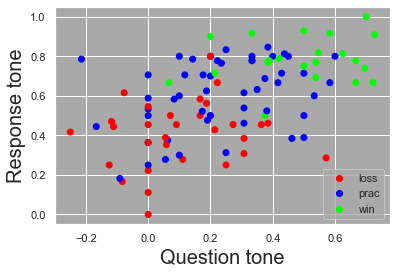

In [90]:
scatter = plt.scatter(x1,y,c=df_rating['win_prac_loss'], cmap=cmap)
plt.xlabel('Question tone', fontsize=20)
plt.ylabel('Response tone', fontsize=20)
plt.legend(handles=scatter.legend_elements()[0], labels = ['loss','prac','win'])
plt.savefig("Tone_analysis.png", format='png', dpi=150)
plt.show()

C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Response Rating PDF')

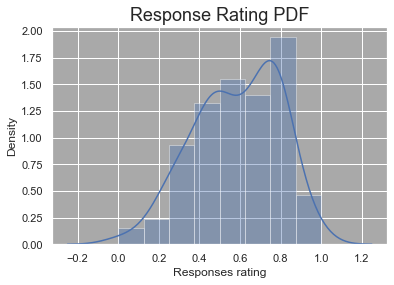

In [91]:
sns.distplot(df_rating['Responses rating'])
plt.title("Response Rating PDF", size=18)

C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Question Rating PDF')

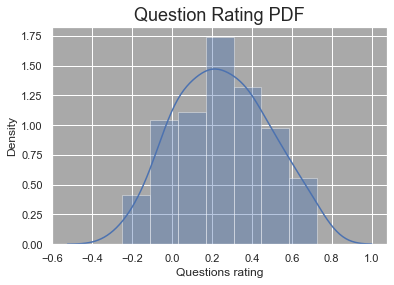

In [92]:
sns.distplot(df_rating['Questions rating'])
plt.title("Question Rating PDF", size=18)

C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Interview Length PDF')

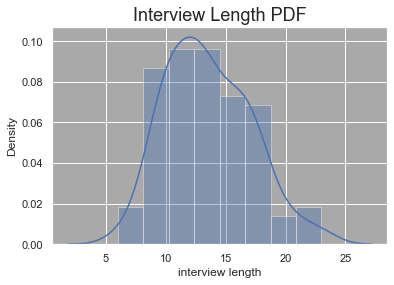

In [93]:
sns.distplot(df_rating['interview length'])
plt.title("Interview Length PDF", size=18)

##### Curves are close to normal

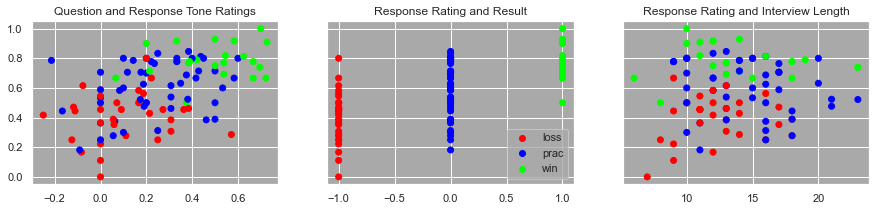

In [94]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Responses rating' as y
ax1.scatter(df_rating['Questions rating'],df_rating['Responses rating'],c=df_rating['win_prac_loss'], cmap=cmap)
ax1.set_title('Question and Response Tone Ratings')
scatter2 = ax2.scatter(df_rating['win_prac_loss'],df_rating['Responses rating'],c=df_rating['win_prac_loss'],cmap=cmap)
ax2.legend(handles=scatter2.legend_elements()[0], labels = ['loss','prac','win'])
ax2.set_title('Response Rating and Result')
ax3.scatter(df_rating['interview length'],df_rating['Responses rating'],c=df_rating['win_prac_loss'],cmap=cmap)
ax3.set_title('Response Rating and Interview Length')
plt.savefig("Variable_analysis.png", format='png', dpi=150)

##### We observe that the ratings correlation is approx. linear. Response ratings tend to be higher in wins, mid to low in losses, and average during practice days. It appears interviews (on average) are a bit longer during practice days, which makes sense given the setting.

##### regression

In [95]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     37.63
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.68e-08
Time:                        18:34:23   Log-Likelihood:                 31.213
No. Observations:                 103   AIC:                            -58.43
Df Residuals:                     101   BIC:                            -53.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4651      0.026     17.609      0.000       0.413       0.517
Questions rating     0.4751      0.077      6.134      0.000       0.321       0.629
==============================================================================
Omnibus:                        2.225   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.329   Jarque-Bera (JB):                2.230
Skew:                          -0.311   Prob(JB):                        0.328
Kurtosis:                       2.635   Cond. No.                         4.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### We see that Questions rating has low standard error. This means the model is fairly accurate in its estimate. 
##### As Questions rating has a p value = 0 we confirm it is valuable in determining the Responses rating.
##### 'low' r-squared implies we are correct in believing there are other variables which influence response tone

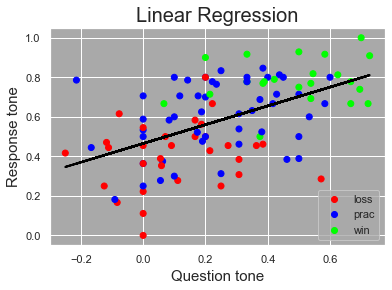

In [96]:
scatter_lin = plt.scatter(x1,y,c=df_rating['win_prac_loss'], cmap=cmap)
inter = 0.4651
yhat = 0.4751*x1 + 0.4651
fig = plt.plot(x1,yhat, lw=2, c='black')
plt.xlabel('Question tone', fontsize=15)
plt.ylabel('Response tone', fontsize=15)
plt.title('Linear Regression', fontsize=20)
plt.legend(handles=scatter_lin.legend_elements()[0], labels = ['loss','prac','win'])
plt.savefig("Simple_lin_reg.png", format='png', dpi=150)
plt.show()

### note: it is likely the same variables which impact question tone also impact the response tone. We may want to avoid this in our analysis when we consider multiple features. Let us explore the correlation coefficient on the win and loss variables.

In [97]:
y = df_rating['Responses rating']
x1 = df_rating['win']

In [98]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     33.12
Date:                Tue, 23 May 2023   Prob (F-statistic):           9.34e-08
Time:                        18:34:24   Log-Likelihood:                 29.509
No. Observations:                 103   AIC:                            -55.02
Df Residuals:                     101   BIC:                            -49.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5306      0.020     26.027      0.000       0.490       0.571
win            0.2539      0.044      5.755      0.000       0.166       0.341
==============================================================================
Omnibus:                        1.886   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.389   Jarque-Bera (JB):                1.921
Skew:                          -0.286   Prob(JB):                        0.383
Kurtosis:                       2.654   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
y = df_rating['Responses rating']
x1 = df_rating['loss']

In [100]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.15
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.56e-09
Time:                        18:34:24   Log-Likelihood:                 33.581
No. Observations:                 103   AIC:                            -63.16
Df Residuals:                     101   BIC:                            -57.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6606      0.021     31.783      0.000       0.619       0.702
loss          -0.2518      0.038     -6.645      0.000      -0.327      -0.177
==============================================================================
Omnibus:                        5.705   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.610
Skew:                          -0.572   Prob(JB):                       0.0605
Kurtosis:                       2.977   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Loss has a stronger relationship to response tone than both win and question tone. Notice that win was very close to the results of question tone, it seems likely we can replace questions tone, a compound variable, by combining multiple simple variables (e.g. win and loss).

## With the information available let us create further variables which may impact the response tone rating of Lebron James.

In [101]:
data = pd.read_csv('Interview_analysis.csv')
df = data.copy()

In [102]:
df['away'] = (df['home'] == 0).astype(int)
df

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away
0,11-Oct-20,9,0.666667,0.777778,0,1,1,1,0,0,1
1,9-Oct-20,8,0.250000,0.250000,0,1,-1,0,1,0,1
2,8-Oct-20,10,0.600000,0.800000,1,0,0,0,0,0,1
3,6-Oct-20,11,0.727273,0.909091,0,1,1,1,0,0,1
4,5-Oct-20,9,0.222222,0.777778,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98,10-Jun-07,12,0.166667,0.583333,0,1,-1,0,1,0,1
99,9-Jun-07,18,0.055556,0.277778,1,0,0,0,0,0,1
100,8-Jun-07,13,0.461538,0.384615,1,0,0,0,0,0,1
101,7-Jun-07,13,-0.076923,0.615385,0,1,-1,0,1,0,1


In [103]:
df['Date'] =  pd.to_datetime(df['Date'], infer_datetime_format = True)
df

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away
0,2020-10-11,9,0.666667,0.777778,0,1,1,1,0,0,1
1,2020-10-09,8,0.250000,0.250000,0,1,-1,0,1,0,1
2,2020-10-08,10,0.600000,0.800000,1,0,0,0,0,0,1
3,2020-10-06,11,0.727273,0.909091,0,1,1,1,0,0,1
4,2020-10-05,9,0.222222,0.777778,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98,2007-06-10,12,0.166667,0.583333,0,1,-1,0,1,0,1
99,2007-06-09,18,0.055556,0.277778,1,0,0,0,0,0,1
100,2007-06-08,13,0.461538,0.384615,1,0,0,0,0,0,1
101,2007-06-07,13,-0.076923,0.615385,0,1,-1,0,1,0,1


In [104]:
##### last game of the series may have an impact on tone, let us consider this feature.
seriesresult = []
lastgos = df.loc[df.groupby(df['Date'].dt.year)['Date'].idxmax()]
lastgos

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away
95,2007-06-14,11,0.363636,0.454545,0,1,-1,0,1,1,0
83,2011-06-12,17,-0.117647,0.470588,0,1,-1,0,1,1,0
73,2012-06-21,10,0.700000,1.000000,0,1,1,1,0,1,0
62,2013-06-20,11,0.545455,0.818182,0,1,1,1,0,1,0
52,2014-06-15,14,0.214286,0.428571,0,1,-1,0,1,0,1
41,2015-06-16,12,-0.083333,0.166667,0,1,-1,0,1,1,0
26,2016-06-19,12,0.583333,0.916667,0,1,1,1,0,0,1
17,2017-06-12,11,0.000000,0.363636,0,1,-1,0,1,0,1
9,2018-06-08,14,0.571429,0.285714,0,1,-1,0,1,1,0
0,2020-10-11,9,0.666667,0.777778,0,1,1,1,0,0,1


In [105]:
lastgos.index

Int64Index([95, 83, 73, 62, 52, 41, 26, 17, 9, 0], dtype='int64')

In [106]:
i = 0
while i < 103:
    if i in lastgos.index:
        q = df.loc[i]
        seriesresult.append(q['win_prac_loss'])
        i+=1
    else:
        seriesresult.append(0)
        i+=1

In [107]:
df['series result'] = seriesresult
df

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away,series result
0,2020-10-11,9,0.666667,0.777778,0,1,1,1,0,0,1,1
1,2020-10-09,8,0.250000,0.250000,0,1,-1,0,1,0,1,0
2,2020-10-08,10,0.600000,0.800000,1,0,0,0,0,0,1,0
3,2020-10-06,11,0.727273,0.909091,0,1,1,1,0,0,1,0
4,2020-10-05,9,0.222222,0.777778,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98,2007-06-10,12,0.166667,0.583333,0,1,-1,0,1,0,1,0
99,2007-06-09,18,0.055556,0.277778,1,0,0,0,0,0,1,0
100,2007-06-08,13,0.461538,0.384615,1,0,0,0,0,0,1,0
101,2007-06-07,13,-0.076923,0.615385,0,1,-1,0,1,0,1,0


#### Depending on how the series is going, one loss may have a larger impact on tone than another. Let us consider the cumulative wins and losses in a series.

In [108]:
cwins = df.groupby(pd.Grouper(key='Date', axis=0, freq='1Y'))['win'].cumsum()
closs = df.groupby(pd.Grouper(key='Date', axis=0, freq='1Y'))['loss'].cumsum()
df['cumulative wins'] = cwins
df['cumulative losses'] = closs
df

,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away,series result,cumulative wins,cumulative losses
0,2020-10-11,9,0.666667,0.777778,0,1,1,1,0,0,1,1,4,2
1,2020-10-09,8,0.250000,0.250000,0,1,-1,0,1,0,1,0,3,2
2,2020-10-08,10,0.600000,0.800000,1,0,0,0,0,0,1,0,3,1
3,2020-10-06,11,0.727273,0.909091,0,1,1,1,0,0,1,0,3,1
4,2020-10-05,9,0.222222,0.777778,1,0,0,0,0,0,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2007-06-10,12,0.166667,0.583333,0,1,-1,0,1,0,1,0,0,2
99,2007-06-09,18,0.055556,0.277778,1,0,0,0,0,0,1,0,0,1
100,2007-06-08,13,0.461538,0.384615,1,0,0,0,0,0,1,0,0,1
101,2007-06-07,13,-0.076923,0.615385,0,1,-1,0,1,0,1,0,0,1


In [109]:
df.to_csv('Interview_analysis_final.csv', index = False)

In [110]:
df.describe()

,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away,series result,cumulative wins,cumulative losses
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,13.543689,0.252095,0.584845,0.485437,0.514563,-0.087379,0.213592,0.300971,0.417476,0.582524,-0.019417,1.087379,1.572816
std,3.541841,0.230707,0.210398,0.502232,0.502232,0.715470,0.411846,0.460923,0.495554,0.495554,0.312504,1.164060,1.062756
min,6.000000,-0.250000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,11.000000,0.069048,0.449495,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,13.000000,0.222222,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,16.000000,0.408333,0.777778,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000
max,23.000000,0.727273,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


### Multivariate Regression

##### we begin by running a regression utilizing all features available (while avoiding multicollinearity)

In [111]:
y = df['Responses rating']
x1 = df[['interview length', 'Questions rating', 'win', 'loss', 'home', 'series result', 'cumulative wins', 'cumulative losses']]

In [112]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     10.90
Date:                Tue, 23 May 2023   Prob (F-statistic):           9.39e-11
Time:                        18:34:24   Log-Likelihood:                 48.703
No. Observations:                 103   AIC:                            -79.41
Df Residuals:                      94   BIC:                            -55.69
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5309      0.075      7.110      0.000       0.383       0.679
interview length      0.0013      0.005      0.254      0.800      -0.009       0.011
Questions rating      0.2099      0.085      2.460      0.016       0.041       0.379
win                   0.0733      0.050      1.457      0.148      -0.027       0.173
loss                 -0.1437      0.045     -3.162      0.002      -0.234      -0.053
home                  0.0188      0.033      0.561      0.576      -0.048       0.085
series result         0.0379      0.061      0.623      0.535      -0.083       0.159
cumulative wins       0.0330      0.018      1.865      0.065      -0.002       0.068
cumulative losses    -0.0200      0.021     -0.971      0.334      -0.061       0.021
==============================================================================
Omnibus:                        2.058   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                2.039
Skew:                          -0.282   Prob(JB):                        0.361
Kurtosis:                       2.602   Cond. No.                         88.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
y = df['Responses rating']
x1 = df[['Questions rating','win', 'loss', 'cumulative wins', 'cumulative losses']]

In [114]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()
##### highest adj R-sq value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     17.69
Date:                Tue, 23 May 2023   Prob (F-statistic):           2.00e-12
Time:                        18:34:24   Log-Likelihood:                 48.285
No. Observations:                 103   AIC:                            -84.57
Df Residuals:                      97   BIC:                            -68.76
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5523      0.035     16.005      0.000       0.484       0.621
Questions rating      0.2138      0.083      2.561      0.012       0.048       0.379
win                   0.0770      0.050      1.554      0.123      -0.021       0.175
loss                 -0.1529      0.041     -3.725      0.000      -0.234      -0.071
cumulative wins       0.0353      0.016      2.169      0.033       0.003       0.068
cumulative losses    -0.0192      0.017     -1.125      0.263      -0.053       0.015
==============================================================================
Omnibus:                        2.087   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.352   Jarque-Bera (JB):                2.103
Skew:                          -0.300   Prob(JB):                        0.349
Kurtosis:                       2.641   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
##### let's remove question rating for previously mentioned concerns (and interview length due to it having lowest probability of relationship)
y = df['Responses rating']
x1 = df[['win', 'loss', 'home', 'series result', 'cumulative wins', 'cumulative losses']]

In [116]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     12.98
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.08e-10
Time:                        18:34:24   Log-Likelihood:                 45.488
No. Observations:                 103   AIC:                            -76.98
Df Residuals:                      96   BIC:                            -58.53
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5872      0.032     18.255      0.000       0.523       0.651
win                   0.1203      0.048      2.529      0.013       0.026       0.215
loss                 -0.1769      0.041     -4.307      0.000      -0.258      -0.095
home                  0.0238      0.034      0.698      0.487      -0.044       0.091
series result         0.0481      0.062      0.777      0.439      -0.075       0.171
cumulative wins       0.0341      0.018      1.920      0.058      -0.001       0.069
cumulative losses    -0.0133      0.020     -0.680      0.498      -0.052       0.025
==============================================================================
Omnibus:                        3.895   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.733
Skew:                          -0.465   Prob(JB):                        0.155
Kurtosis:                       2.932   Cond. No.                         9.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
# refine variables based on level of significance
y = df['Responses rating']
x1 = df[['win', 'loss', 'cumulative wins', 'cumulative losses']]

In [118]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     19.38
Date:                Tue, 23 May 2023   Prob (F-statistic):           8.98e-12
Time:                        18:34:24   Log-Likelihood:                 44.916
No. Observations:                 103   AIC:                            -79.83
Df Residuals:                      98   BIC:                            -66.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5947      0.031     19.106      0.000       0.533       0.656
win                   0.1263      0.047      2.689      0.008       0.033       0.220
loss                 -0.1842      0.040     -4.572      0.000      -0.264      -0.104
cumulative wins       0.0382      0.017      2.287      0.024       0.005       0.071
cumulative losses    -0.0146      0.017     -0.836      0.405      -0.049       0.020
==============================================================================
Omnibus:                        3.786   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.696
Skew:                          -0.460   Prob(JB):                        0.158
Kurtosis:                       2.873   Cond. No.                         7.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### large increase in adj R-squared and each variable is significant. Durbin-Watson variable implies we are safe from autocorrelation. Our F-statistic is large and thus implies that our model is significant.
##### however, clearly the tone of Lebron James' responses is a complex variable to predict. Notice that all of the adj. R-squared statistics are in the 0.4 to 0.5 range. For social sciences, and the study of response tone, this is an acceptable range.
##### other combination of independent variables were tested and this was determined to be the best for predicting future tones with easily accessible data (question tone would require querying ChatGPT and calculations to be made.)

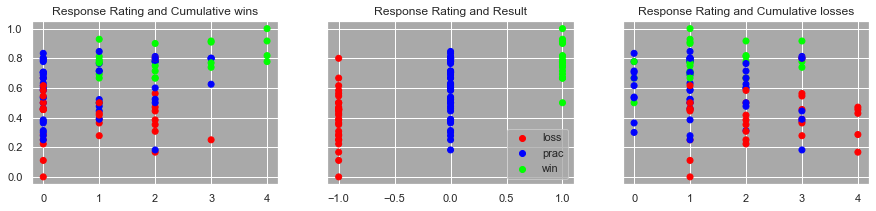

In [119]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) 
scatter1 = ax1.scatter(df['cumulative wins'],df['Responses rating'],c=df['win_prac_loss'],cmap=cmap)
ax1.set_title('Response Rating and Cumulative wins')
scatter2 = ax2.scatter(df_rating['win_prac_loss'],df_rating['Responses rating'],c=df_rating['win_prac_loss'],cmap=cmap)
ax2.legend(handles=scatter2.legend_elements()[0], labels = ['loss','prac','win'])
ax2.set_title('Response Rating and Result')
ax3.scatter(df['cumulative losses'],df['Responses rating'],c=df['win_prac_loss'],cmap=cmap)
ax3.set_title('Response Rating and Cumulative losses')
plt.savefig("Chosen_Variable_analysis.png", format='png', dpi=200)

### Feature analysis

In [120]:
y = df['Responses rating']
x = df[['cumulative wins', 'cumulative losses', 'win', 'loss']]

In [121]:
from sklearn.feature_selection import f_regression

In [122]:
f_regression(x,y)

(array([17.10249848,  4.8613282 , 33.11870828, 44.15443711]),
 array([7.33400480e-05, 2.97340136e-02, 9.34094984e-08, 1.56228842e-09]))

### Multivariate Regression Predictions

In [123]:
reg = LinearRegression()
reg.fit(x,y)
scaler = StandardScaler()

In [124]:
reg_summary = pd.DataFrame([['Bias'], ['win'], ['loss'], ['cumulative wins'], ['cumulative losses']], columns=['Features'])
reg_summary['weights'] = reg.intercept_, reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.coef_[3]
reg_summary

,Features,weights
0,Bias,0.594684
1,win,0.038215
2,loss,-0.014584
3,cumulative wins,0.126310
4,cumulative losses,-0.184183


In [125]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=37)
normalized_x_train = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns = x_train.columns
)

reg.fit(normalized_x_train,y_train)
y_hat = reg.predict(normalized_x_train)

normalized_x_test = pd.DataFrame(
    scaler.transform(x_test),
    columns = x_test.columns
)
y_hat_test = reg.predict(normalized_x_test)

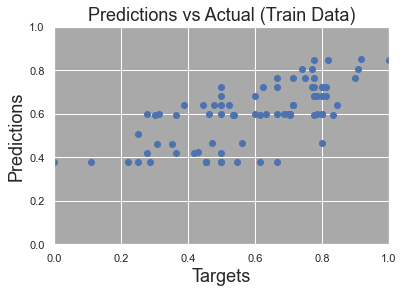

In [126]:
plt.scatter(y_train, y_hat)
# name the axes
plt.xlabel('Targets',size=18)
plt.ylabel('Predictions',size=18)
plt.title("Predictions vs Actual (Train Data)", size=18)
# same axis values
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Train Residuals PDF')

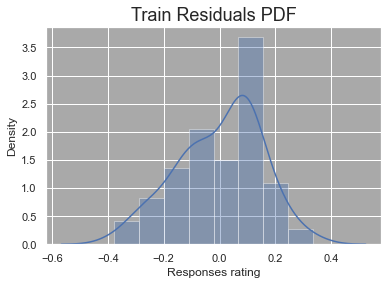

In [127]:
sns.distplot(y_train - y_hat)
plt.title("Train Residuals PDF", size=18)

In [128]:
reg.score(normalized_x_train, y_train)
##### note this is not the adjusted R-squared value. Also, Adj R^2 is always less than R^2. 

0.46912660135818307

In [129]:
reg.intercept_

0.5938744047195121

In [130]:
reg.coef_

array([ 0.05006084,  0.00040873,  0.03413846, -0.10034872])

In [131]:
reg_summary = pd.DataFrame(x.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,cumulative wins,0.050061
1,cumulative losses,0.000409
2,win,0.034138
3,loss,-0.100349


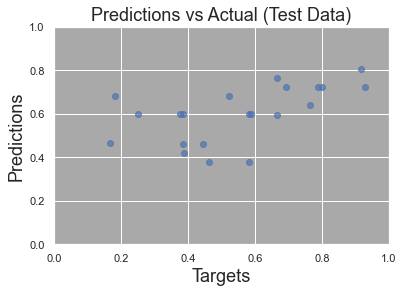

In [132]:
plt.scatter(y_test, y_hat_test, alpha=0.7)
plt.xlabel('Targets',size=18)
plt.ylabel('Predictions',size=18)
plt.title("Predictions vs Actual (Test Data)", size=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [133]:
df_predictions = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_predictions.head()

,Prediction
0,0.379080
1,0.597823
2,0.379461
3,0.765307
4,0.464257


In [134]:
y_test = y_test.reset_index(drop=True)
df_predictions['Target'] = y_test
df_predictions

,Prediction,Target
0,0.379080,0.461538
1,0.597823,0.375000
2,0.379461,0.583333
3,0.765307,0.666667
4,0.464257,0.166667
5,0.463113,0.444444
6,0.597060,0.588235
7,0.597060,0.384615
8,0.596679,0.666667
9,0.597060,0.583333


In [135]:
df_predictions['Residual'] = df_predictions['Target'] - df_predictions['Prediction']
df_predictions['Difference%'] = np.absolute(df_predictions['Residual']/df_predictions['Target']*100)
df_predictions

,Prediction,Target,Residual,Difference%
0,0.379080,0.461538,0.082459,17.866087
1,0.597823,0.375000,-0.222823,59.419379
2,0.379461,0.583333,0.203873,34.949589
3,0.765307,0.666667,-0.098640,14.796010
4,0.464257,0.166667,-0.297590,178.554074
5,0.463113,0.444444,-0.018669,4.200515
6,0.597060,0.588235,-0.008825,1.500270
7,0.597060,0.384615,-0.212445,55.235706
8,0.596679,0.666667,0.069987,10.498108
9,0.597060,0.583333,-0.013727,2.353213


In [136]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_predictions.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
6,0.60,0.59,-0.01,1.50
9,0.60,0.58,-0.01,2.35
5,0.46,0.44,-0.02,4.20
19,0.72,0.69,-0.03,4.48
18,0.72,0.79,0.07,8.38
16,0.42,0.39,-0.03,8.48
13,0.72,0.80,0.08,9.52
8,0.60,0.67,0.07,10.50
11,0.81,0.92,0.11,11.89
3,0.77,0.67,-0.10,14.80


C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Residuals PDF')

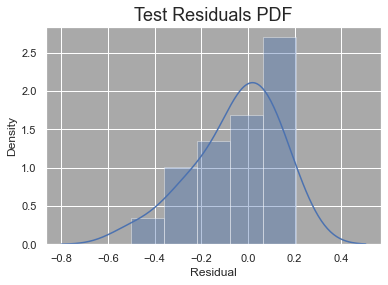

In [137]:
sns.distplot(df_predictions['Residual'])
plt.title("Test Residuals PDF", size=18)

In [138]:
df_predictions.describe()

,Prediction,Target,Residual,Difference%
count,21.00,21.00,21.00,21.00
mean,0.60,0.55,-0.05,44.05
std,0.13,0.22,0.18,69.64
min,0.38,0.17,-0.50,1.50
25%,0.46,0.38,-0.16,8.48
50%,0.60,0.58,-0.02,16.38
75%,0.72,0.69,0.08,34.95
max,0.81,0.93,0.21,275.02


### Let's split our ratings into two groups: a rating greater than 0.5 will be considered 'more positive' and a rating less than or equal to 0.5 will be considered 'more neutral'.

In [139]:
pred_tone = []
for ele in df_predictions['Prediction']:
    if ele > 0.5:
        pred_tone.append(1)
    else:
        pred_tone.append(0)

In [140]:
target_tone = []
for ele in df_predictions['Target']:
    if ele > 0.5:
        target_tone.append(1)
    else:
        target_tone.append(0)

In [141]:
df_predictions['predicted tone'] = pred_tone
df_predictions['target tone'] = target_tone
df_predictions

,Prediction,Target,Residual,Difference%,predicted tone,target tone
0,0.38,0.46,0.08,17.87,0,0
1,0.60,0.38,-0.22,59.42,1,0
2,0.38,0.58,0.20,34.95,0,1
3,0.77,0.67,-0.10,14.80,1,1
4,0.46,0.17,-0.30,178.55,0,0
5,0.46,0.44,-0.02,4.20,0,0
6,0.60,0.59,-0.01,1.50,1,1
7,0.60,0.38,-0.21,55.24,1,0
8,0.60,0.67,0.07,10.50,1,1
9,0.60,0.58,-0.01,2.35,1,1


In [142]:
y_true = df_predictions['target tone']
y_pred = df_predictions['predicted tone']

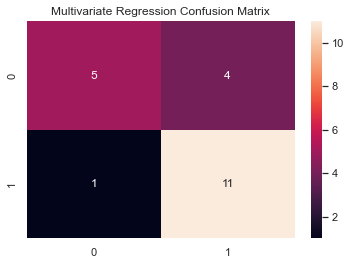

In [143]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)
disp = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
disp.set_title('Multivariate Regression Confusion Matrix')
plt.show()

In [144]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7619047619047619

In [145]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)

array([0.55555556, 0.91666667])

In [146]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

array([0.83333333, 0.73333333])

In [147]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.66666667, 0.81481481])

### The practice interviews add unpredictability to the data (as win/loss was thought to be an easy prediction). However, since 60% of interviews were positive despite losing 60% of games-it is worth exploring. 

In [148]:
df_no_prac = df[df['practice']==0]
df_no_prac = df_no_prac.reset_index()
df_no_prac

,index,Date,interview length,Questions rating,Responses rating,practice,game,win_prac_loss,win,loss,home,away,series result,cumulative wins,cumulative losses
0,0,2020-10-11,9,0.67,0.78,0,1,1,1,0,0,1,1,4,2
1,1,2020-10-09,8,0.25,0.25,0,1,-1,0,1,0,1,0,3,2
2,3,2020-10-06,11,0.73,0.91,0,1,1,1,0,0,1,0,3,1
3,5,2020-10-04,9,-0.11,0.44,0,1,-1,0,1,0,1,0,2,1
4,6,2020-10-02,6,0.67,0.67,0,1,1,1,0,0,1,0,2,0
5,7,2020-09-30,8,0.38,0.50,0,1,1,1,0,0,1,0,1,0
6,9,2018-06-08,14,0.57,0.29,0,1,-1,0,1,1,0,-1,0,4
7,11,2018-06-06,11,0.27,0.45,0,1,-1,0,1,1,0,0,0,3
8,13,2018-06-03,9,0.22,0.67,0,1,-1,0,1,0,1,0,0,2
9,15,2018-05-31,16,-0.12,0.25,0,1,-1,0,1,0,1,0,0,1


In [149]:
df_no_prac = df_no_prac.drop('index', axis = 1)
df_no_prac.to_csv('Interview_analysis_final_np.csv', index = False)

In [150]:
y = df_no_prac['Responses rating']
x1 = df_no_prac[['interview length', 'Questions rating', 'win', 'home', 'series result', 'cumulative wins', 'cumulative losses']]

In [151]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     12.91
Date:                Tue, 23 May 2023   Prob (F-statistic):           5.77e-09
Time:                        18:34:26   Log-Likelihood:                 30.861
No. Observations:                  53   AIC:                            -45.72
Df Residuals:                      45   BIC:                            -29.96
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3030      0.083      3.629      0.001       0.135       0.471
interview length      0.0055      0.007      0.808      0.423      -0.008       0.019
Questions rating      0.0798      0.120      0.667      0.508      -0.161       0.321
win                   0.3220      0.081      3.987      0.000       0.159       0.485
home                 -0.0179      0.044     -0.407      0.686      -0.106       0.071
series result         0.1076      0.063      1.708      0.095      -0.019       0.234
cumulative wins       0.0008      0.024      0.032      0.975      -0.048       0.050
cumulative losses     0.0252      0.028      0.885      0.381      -0.032       0.083
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.350
Skew:                          -0.198   Prob(JB):                        0.840
Kurtosis:                       2.962   Cond. No.                         91.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
y = df_no_prac['Responses rating']
x1 = df_no_prac[['Questions rating','win', 'cumulative wins', 'cumulative losses']]

In [153]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     21.42
Date:                Tue, 23 May 2023   Prob (F-statistic):           3.45e-10
Time:                        18:34:26   Log-Likelihood:                 28.818
No. Observations:                  53   AIC:                            -47.64
Df Residuals:                      48   BIC:                            -37.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3646      0.053      6.937      0.000       0.259       0.470
Questions rating      0.1086      0.117      0.927      0.359      -0.127       0.344
win                   0.3179      0.075      4.234      0.000       0.167       0.469
cumulative wins       0.0174      0.021      0.815      0.419      -0.025       0.060
cumulative losses     0.0082      0.022      0.368      0.715      -0.037       0.053
==============================================================================
Omnibus:                        0.762   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.281
Skew:                          -0.149   Prob(JB):                        0.869
Kurtosis:                       3.197   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
y = df_no_prac['Responses rating']
x1 = df_no_prac[['win', 'series result', 'cumulative wins', 'cumulative losses']]

In [155]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     23.28
Date:                Tue, 23 May 2023   Prob (F-statistic):           9.70e-11
Time:                        18:34:26   Log-Likelihood:                 30.248
No. Observations:                  53   AIC:                            -50.50
Df Residuals:                      48   BIC:                            -40.65
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3548      0.051      6.890      0.000       0.251       0.458
win                   0.3673      0.056      6.597      0.000       0.255       0.479
series result         0.1143      0.061      1.889      0.065      -0.007       0.236
cumulative wins      -0.0030      0.023     -0.129      0.898      -0.050       0.044
cumulative losses     0.0353      0.024      1.463      0.150      -0.013       0.084
==============================================================================
Omnibus:                        1.629   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.443   Jarque-Bera (JB):                0.883
Skew:                          -0.255   Prob(JB):                        0.643
Kurtosis:                       3.372   Cond. No.                         9.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
y = df_no_prac['Responses rating']
x1 = df_no_prac[['win', 'series result', 'cumulative losses']]

In [157]:
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Responses rating   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     31.67
Date:                Tue, 23 May 2023   Prob (F-statistic):           1.58e-11
Time:                        18:34:26   Log-Likelihood:                 30.239
No. Observations:                  53   AIC:                            -52.48
Df Residuals:                      49   BIC:                            -44.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3550      0.051      6.970      0.000       0.253       0.457
win                   0.3632      0.045      8.026      0.000       0.272       0.454
series result         0.1107      0.053      2.082      0.043       0.004       0.218
cumulative losses     0.0338      0.021      1.618      0.112      -0.008       0.076
==============================================================================
Omnibus:                        1.553   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                0.832
Skew:                          -0.253   Prob(JB):                        0.660
Kurtosis:                       3.348   Cond. No.                         7.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

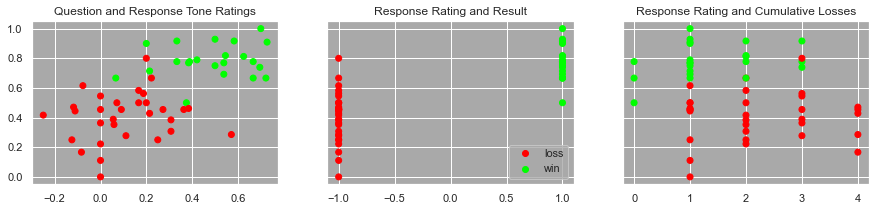

In [158]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Responses rating' as y
ax1.scatter(df_no_prac['Questions rating'],df_no_prac['Responses rating'],c=df_no_prac['win_prac_loss'], cmap=cmap)
ax1.set_title('Question and Response Tone Ratings')
scatter2 = ax2.scatter(df_no_prac['win_prac_loss'],df_no_prac['Responses rating'],c=df_no_prac['win_prac_loss'],cmap=cmap)
ax2.legend(handles=scatter2.legend_elements()[0], labels = ['loss','win'])
ax2.set_title('Response Rating and Result')
ax3.scatter(df_no_prac['cumulative losses'],df_no_prac['Responses rating'],c=df_no_prac['win_prac_loss'],cmap=cmap)
ax3.set_title('Response Rating and Cumulative Losses')
plt.savefig("Variable_analysis_noprac.png", format='png', dpi=150)

In [159]:
y_np = df_no_prac['Responses rating']
x_np = df_no_prac[['series result', 'cumulative losses', 'win']]

In [160]:
f_regression(x_np,y_np)

(array([13.67374652,  3.01528125, 84.35301682]),
 array([5.32523287e-04, 8.85208702e-02, 2.16018638e-12]))

In [161]:
reg_summary_np = pd.DataFrame([['Bias'], ['series result'], ['cumulative losses'], ['win']], columns=['Features'])
reg_summary_np['weights'] = reg.intercept_, reg.coef_[0], reg.coef_[1], reg.coef_[2]
reg_summary_np

,Features,weights
0,Bias,0.59
1,series result,0.05
2,cumulative losses,0.00
3,win,0.03


In [162]:
x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(x_np, y_np, test_size=0.2, random_state=37)
normalized_x_train_np = pd.DataFrame(
    scaler.fit_transform(x_train_np),
    columns = x_train_np.columns
)

reg.fit(normalized_x_train_np,y_train_np)
y_hat_np = reg.predict(normalized_x_train_np)

normalized_x_test_np = pd.DataFrame(
    scaler.transform(x_test_np),
    columns = x_test_np.columns
)
y_hat_test_np = reg.predict(normalized_x_test_np)

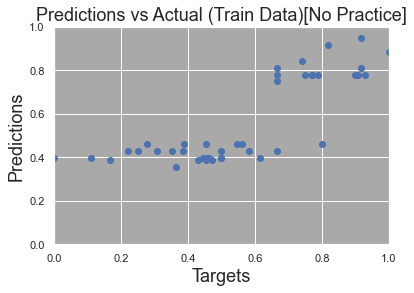

In [163]:
plt.scatter(y_train_np, y_hat_np)
# name the axes
plt.xlabel('Targets',size=18)
plt.ylabel('Predictions',size=18)
plt.title("Predictions vs Actual (Train Data)[No Practice]", size=18)
# same axis values
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Train Residuals PDF [No practice]')

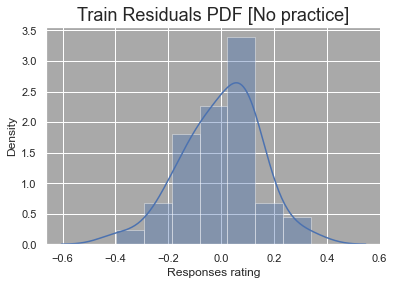

In [164]:
sns.distplot(y_train_np - y_hat_np)
plt.title("Train Residuals PDF [No practice]", size=18)

In [165]:
reg.score(normalized_x_train_np, y_train_np)
##### note this is not the adjusted R-squared value. Also, Adj R^2 is always less than R^2. 

0.6445511012833833

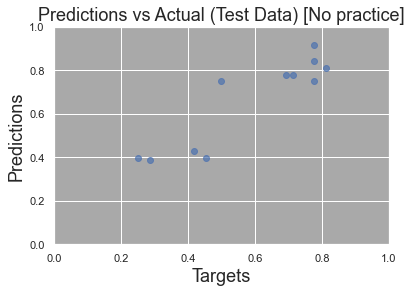

In [166]:
plt.scatter(y_test_np, y_hat_test_np, alpha=0.7)
plt.xlabel('Targets',size=18)
plt.ylabel('Predictions',size=18)
plt.title("Predictions vs Actual (Test Data) [No practice]", size=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [167]:
df_predictions_np = pd.DataFrame(y_hat_test_np, columns=['Prediction'])
df_predictions_np.head()

,Prediction
0,0.40
1,0.78
2,0.40
3,0.39
4,0.92


In [168]:
y_test_np = y_test_np.reset_index(drop=True)
df_predictions_np['Target'] = y_test_np
df_predictions_np

,Prediction,Target
0,0.40,0.25
1,0.78,0.69
2,0.40,0.45
3,0.39,0.29
4,0.92,0.78
5,0.43,0.42
6,0.75,0.50
7,0.78,0.71
8,0.84,0.78
9,0.75,0.78


In [169]:
df_predictions_np['Residual'] = df_predictions_np['Target'] - df_predictions_np['Prediction']
df_predictions_np['Difference%'] = np.absolute(df_predictions_np['Residual']/df_predictions_np['Target']*100)
df_predictions_np

,Prediction,Target,Residual,Difference%
0,0.40,0.25,-0.15,59.00
1,0.78,0.69,-0.09,12.70
2,0.40,0.45,0.06,12.55
3,0.39,0.29,-0.10,35.10
4,0.92,0.78,-0.14,17.84
5,0.43,0.42,-0.01,2.89
6,0.75,0.50,-0.25,49.81
7,0.78,0.71,-0.07,9.24
8,0.84,0.78,-0.06,8.34
9,0.75,0.78,0.03,3.69


In [170]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_predictions_np.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
10,0.81,0.81,0.00,0.13
5,0.43,0.42,-0.01,2.89
9,0.75,0.78,0.03,3.69
8,0.84,0.78,-0.06,8.34
7,0.78,0.71,-0.07,9.24
2,0.40,0.45,0.06,12.55
1,0.78,0.69,-0.09,12.70
4,0.92,0.78,-0.14,17.84
3,0.39,0.29,-0.10,35.10
6,0.75,0.50,-0.25,49.81


C:\Users\Bryce\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Residuals PDF [No practice]')

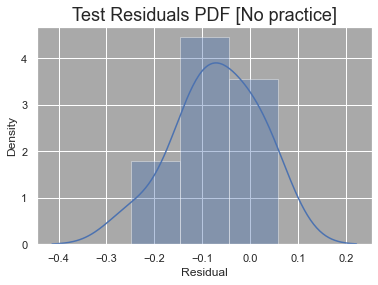

In [171]:
sns.distplot(df_predictions_np['Residual'])
plt.title("Test Residuals PDF [No practice]", size=18)

In [172]:
pred_tone_np = []
for ele in df_predictions_np['Prediction']:
    if ele > 0.5:
        pred_tone_np.append(1)
    else:
        pred_tone_np.append(0)

In [173]:
target_tone_np = []
for ele in df_predictions_np['Target']:
    if ele > 0.5:
        target_tone_np.append(1)
    else:
        target_tone_np.append(0)

In [174]:
df_predictions_np['predicted tone'] = pred_tone_np
df_predictions_np['target tone'] = target_tone_np
df_predictions_np

,Prediction,Target,Residual,Difference%,predicted tone,target tone
0,0.40,0.25,-0.15,59.00,0,0
1,0.78,0.69,-0.09,12.70,1,1
2,0.40,0.45,0.06,12.55,0,0
3,0.39,0.29,-0.10,35.10,0,0
4,0.92,0.78,-0.14,17.84,1,1
5,0.43,0.42,-0.01,2.89,0,0
6,0.75,0.50,-0.25,49.81,1,0
7,0.78,0.71,-0.07,9.24,1,1
8,0.84,0.78,-0.06,8.34,1,1
9,0.75,0.78,0.03,3.69,1,1


In [175]:
y_true_np = df_predictions_np['target tone']
y_pred_np = df_predictions_np['predicted tone']

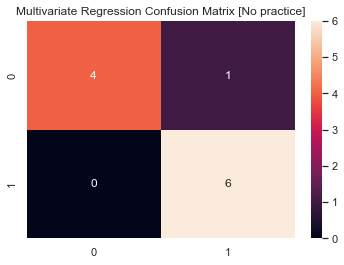

In [176]:
confusion_matrix(y_true_np, y_pred_np)
disp_np = sns.heatmap(confusion_matrix(y_true_np, y_pred_np), annot=True)
disp_np.set_title('Multivariate Regression Confusion Matrix [No practice]')
plt.show()

In [177]:
accuracy_score(y_true_np, y_pred_np)

0.9090909090909091

In [178]:
recall_score(y_true_np, y_pred_np, average=None)

array([0.8, 1. ])

In [179]:
precision_score(y_true_np, y_pred_np, average=None)

array([1.        , 0.85714286])

In [180]:
f1_score(y_true_np, y_pred_np, average=None)

array([0.88888889, 0.92307692])

##### Notice that the only incorrect prediction was a 0.5 rating being considered 'more neutral' - whereas the target (0.75) was deemed 'more positive'. We could have easily declared <0.5 to be 'more neutral' and thus receiving 100% acc. These results support the suggestion that removing practice interviews results in too high of predictability.

### Next, we will test multiple ML methods and select the best performing ones to predict tone on a test set of data.